**Before You Start**: Make sure that you ran `local_0_setup_workshop.ipynb` before!

# Predictive Maintenance With Darts

In this notebook, we'll show how to perform a predictive maintenance task using Darts on the example of Wind Turbine Failures. We will look at:
- which features to use (and not use) for modelling
- how to setup and train a model to predict the expected normal operating range of a signal
- how to detect anomalies from deviations between the actual signal values and the predicted operating range

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries

from src.predictive_maintenance import df_anom_to_series

## Data Loading

In [3]:
# the data has a 10 minute frequency
FREQ = pd.tseries.frequencies.to_offset("10min")

data_dir = os.path.join("data", "pdm")
fpath_data = os.path.join(data_dir, f"Wind-Turbine-SCADA-signals-2016.csv")
fpath_failures = os.path.join(data_dir, f"Historical-Failure-Logbook-2016.csv")

# get the turbine signal data
df_data = pd.read_csv(fpath_data)
df_data.index = pd.DatetimeIndex(df_data["Timestamp"])
df_data = df_data.drop(columns="Timestamp")

# get the failure logbook
df_anom_true = pd.read_csv(fpath_failures)
df_anom_true["start"] = pd.to_datetime(df_anom_true["start"])
df_anom_true["end"] = pd.to_datetime(df_anom_true["end"])

# convert the logbook into a TimeSeries of binary anomalies
anom_true = df_anom_to_series(df_anom_true)

## Data Investigation

### Generator Anomalies

Let's look at the anomalies of Turbine 6 and 7.

In [4]:
# turbine specific anomalies
df_anom_true[df_anom_true["Turbine_ID"] == "T06"]

Turbine_ID        Component            Timestamp  \
1        T06  HYDRAULIC_GROUP  2016-04-04 18:50:00   
2        T06        GENERATOR  2016-07-11 19:50:00   
3        T06        GENERATOR  2016-07-24 17:00:00   
4        T06        GENERATOR  2016-09-04 08:10:00   
5        T06        GENERATOR  2016-10-02 17:10:00   
6        T06        GENERATOR  2016-10-27 16:30:00   

                                             Remarks               start  \
1                          Error in pitch regulation 2016-04-04 18:50:00   
2                                 Generator replaced 2016-07-11 19:50:00   
3               Generator temperature sensor failure 2016-07-24 17:00:00   
4                   High temperature generator error 2016-09-04 08:10:00   
5  Refrigeration system and temperature sensors i... 2016-10-02 17:10:00   
6                                 Generator replaced 2016-10-27 16:30:00   

                  end  
1 2016-04-05 18:40:00  
2 2016-07-12 19:40:00  
3 2016-07-25 16:50:00  
4 2016-09-05 08:00:00  
5 2016-10-03 17:00:00  
6 2016-10-28 16:20:00

In [5]:
df_anom_true[df_anom_true["Turbine_ID"] == "T07"]

Turbine_ID          Component            Timestamp  \
7        T07  GENERATOR_BEARING  2016-04-30 12:40:00   
8        T07        TRANSFORMER  2016-07-10 03:50:00   
9        T07        TRANSFORMER  2016-08-23 02:20:00   

                                             Remarks               start  \
7  High temperature in generator bearing (replace... 2016-04-30 12:40:00   
8                       High temperature transformer 2016-07-10 03:50:00   
9  High temperature transformer. Transformer refr... 2016-08-23 02:20:00   

                  end  
7 2016-05-01 12:30:00  
8 2016-07-11 03:40:00  
9 2016-08-24 02:10:00

It seems there were many anomalies related to the generator. There were 5 anomalies related to the generator in turbine 6 and 1 in turbine 7. Also, most of the anomalies indicate that there was an issue with high temperatures, or malfunctioning temperature sensors. 

For this exercise, we'll only focus on anomalies related to the generator. Specifically, let's try to model one of the generator temperature signals.

In [6]:
# select only generator speicifc anomalies
df_anom_true_gen = df_anom_true[df_anom_true["Component"].str.contains("GENERATOR")].reset_index(drop=True)

# convert the logbook into a TimeSeries of binary anomalies
anom_true_gen = df_anom_to_series(df_anom_true_gen)

### Target Variable Analysis (Generator Bearing Temperature)

We select the target and covariates features as discussed in the presentation.

The generator bearing temperature is the target feature/signal that we want to model. The location of the generator bearing can be found in [hello](#External-Feature-Analysis).

To make the code a bit easier, we already extract the covariates here as well, and refer to turbine 6 as `train` and turbine 7 as `test`.

Now let's extract the signal data per turbine and create a TimeSeries from it. 

In [7]:
# train and test turbine IDs
turbine_id_train, turbine_id_test = "T06", "T07"

# target feature (we explain more later)
tg_col = 'Gen_Bear_Temp_Avg'

# external features (we explain more later)
cov_cols = [
    "Gen_RPM_Max",
    "Nac_Temp_Avg",
    "timer_on_off",
    "missing_date",
    "Prod_LatestAvg_ActPwrGen0",
    "Prod_LatestAvg_ActPwrGen1",
]

# extract turbine specific signal data
df_train = df_data.loc[df_data["Turbine_ID"] == turbine_id_train, cov_cols + [tg_col]].copy()
df_test = df_data.loc[df_data["Turbine_ID"] == turbine_id_test, cov_cols + [tg_col]].copy()

# extract the TimeSeries
train_raw = TimeSeries.from_dataframe(df_train, fill_missing_dates=True, freq=FREQ)
test_raw = TimeSeries.from_dataframe(df_test, fill_missing_dates=True, freq=FREQ)

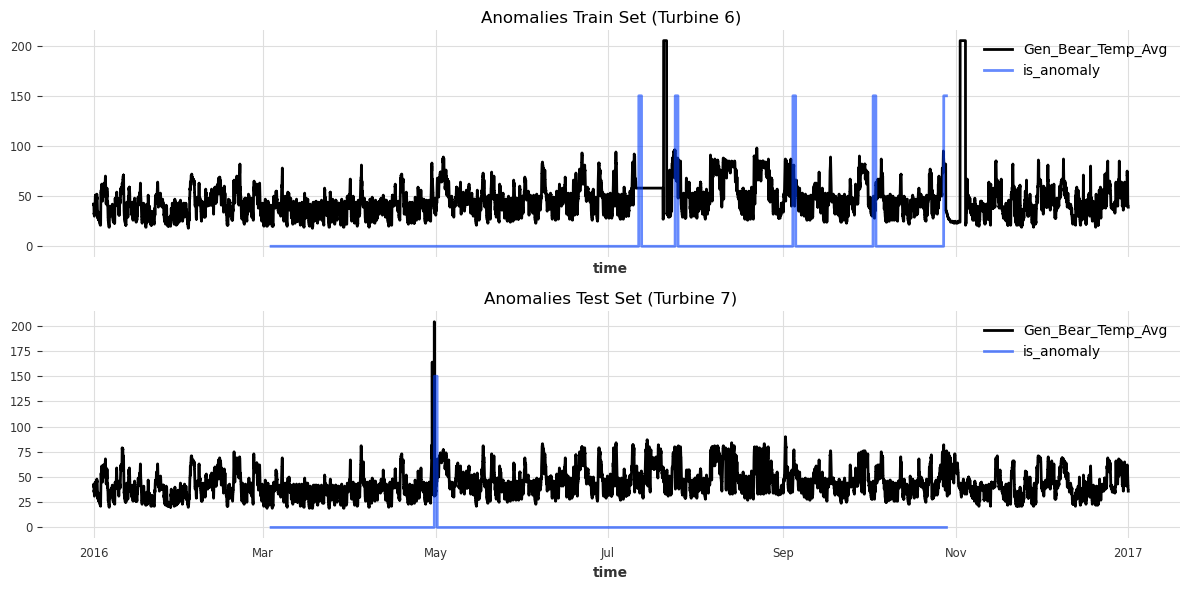

In [8]:
def plot_series(train, test, anom_true):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
    train[tg_col].plot(ax=ax1)
    (anom_true[turbine_id_train] * 150).plot(label="is_anomaly", alpha=0.6, ax=ax1)
    ax1.set_title("Anomalies Train Set (Turbine 6)")
    
    test[tg_col].plot(ax=ax2)
    (anom_true[turbine_id_test] * 150).plot(label="is_anomaly", alpha=0.6, ax=ax2)
    ax2.set_title("Anomalies Test Set (Turbine 7)")
    fig.tight_layout()
    plt.show()

plot_series(train_raw, test_raw, anom_true_gen)

> We reference the anomalies here as 1,2, ... from left to right

**Turbine 6:**
- Anomalies 1 and 5 in Turbine 6 were generator replacements. They are followed by a short time when the turbine was inactive (missing dates).
- Anomaly 2 was a temperature sensor failure, but it seems it could have been detected earlier
- Anomalies 3 (high temperature generator error) and 4 (refrigeration system and temperature sensor replaced) seem to be less obvious from a visual inspection

**Turbine 7:**
- There was only one anomaly related to the generator (high temperature in generator bearing). It also clearly visible, the predictive maintenance model should have an easy time finding this.

And now a quick glance at the distribution of the temperature.

Gen_Bear_Temp_Avg_T06    44.0
Gen_Bear_Temp_Avg_T07    42.0
dtype: float64

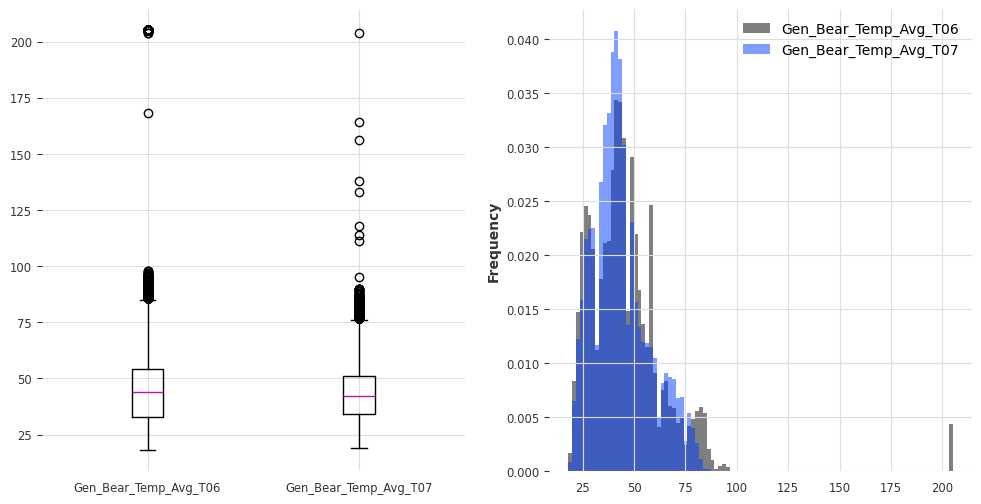

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
df_targets = pd.concat([df_train[tg_col], df_test[tg_col]], axis=1)
df_targets.columns += ["_" + turbine_id_train, "_" + turbine_id_test]
df_targets.boxplot(ax=ax1)
df_targets.plot.hist(bins=100, alpha=0.5, density=True, ax=ax2)
df_targets.median()

From the above, we can already spot the outliers at 200°C, which are related to high temperature errors (and usually followed by a replacement of the sensor)

Also, we could estimate here that normal temperature range lies between roughly 20 - 100°C. We'll later see how to make the model learn this.

If we went with only the distribution itself, we could only mark outliers as anomalies. However, this is not enough to detect anomalies 1, 3, and 4 in turbine 6. For these, we would have to analyze the temperature in relation to the other signals/measurements.

And that is exactly what we want to do in this exercise. We want to build a predictive maintenance model, which estimates the normal operating range of the temperature at any time `t` based on some input signals.

### External Feature Analysis

Predictive maintenance is usually performed by analyzing device behavior in the most recent past (post hoc). In case there is abnormal device behavior, the model/tool should raise an alarm before serious damage occurs.

Because it's done post hoc, we can model for example the generator temperature at all times `t` with actual measurement data from other sensors at times `t` (in regular forecasting, we wouldn't know these values as they lie in the future). 

For this example, we want to estimate the normal operating range for the generator bearing temperature only based on **uni-directional causal signals**.

> Uni-directional causal: We'll only use external features (covariates) that can cause the temperature to change but which are not themselves affected by a change in temperature.
>
> Example of a **good feature**: the rotational speed of the generator shaft. The kinetic energy causes heat buildup in the generator. The rotational speed is also related with the amount of generated power (heat source).
> 
> Example of a **bad feature**: A temperature sensor that is located close to the one we're modelling, would most likely also be affected by a temperature anomaly in the generator. Using such signals as model input would make the anomalous behavior predictable, which is not what we want. We only want the normal operating range.


The pre-selected external features / measurements (covariates) are listed and shown in images below:

- **Gen_Bearing_Temp_Avg [°C]**: Average generator bearing temperature.
- **Gen_RPM_Max [RPM]**: Maximum rotations per minute in the 10 minutes interval.
- **Nac_Temp_Avg [°C]**: Average temperature of the nacelle (the housing).
- **timer_on_off [-]**: Generated feature; counts the number of steps since the last time Gen_RPM_Max crossed the 1200 RPM mark (positive if it went from below 1200 RPM to above, and negative otherwise). It has an upper- and lower threshold of +/- 24 (=4 hours in 10 minute steps). It can be seen as a proxy for heat build-up and stagnation over time.
- **missing_date [-]**: Generated feature; whether the date was missing in the dataset.
- **Prod_LatestAvg_ActPwerGen0/1 [W]**: Average Power Production by generator 0/1.

![covariates-illustration](./images/wind-turbine-components.jpg)
![covariates-illustration](./images/wind_turb_gen_bearing.jpg)

Let's investigate the covariates for turbine 6. We'll show:
- Covariates over time against the temperature (we scale the covariates to a value range of (0, 1) to make them better visible)
- Correlation Heatmap with the temperature

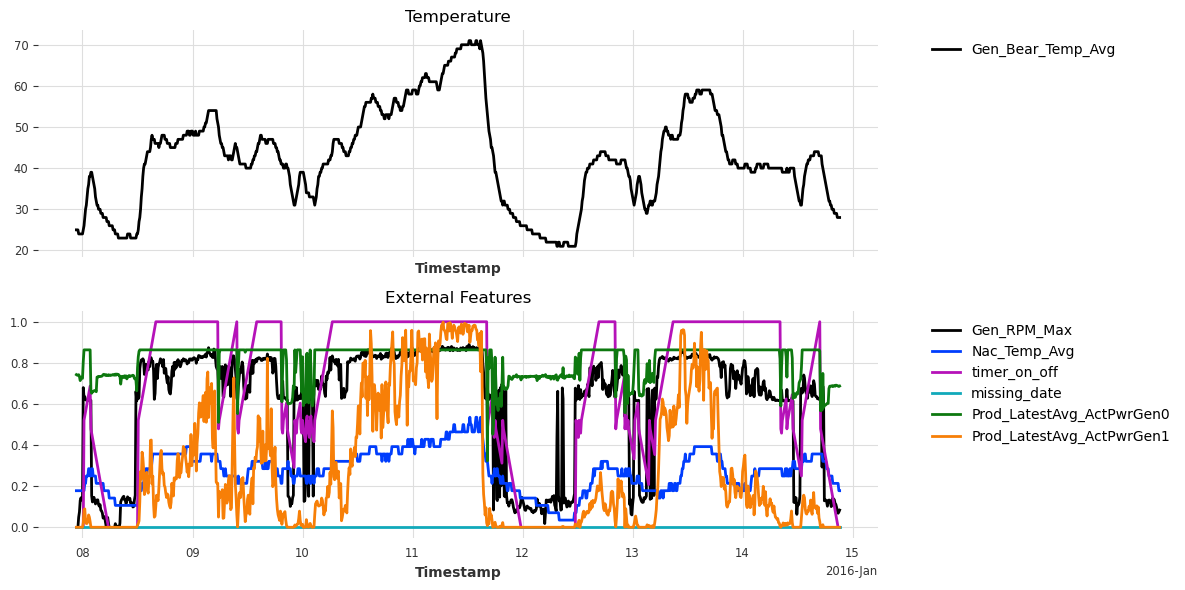

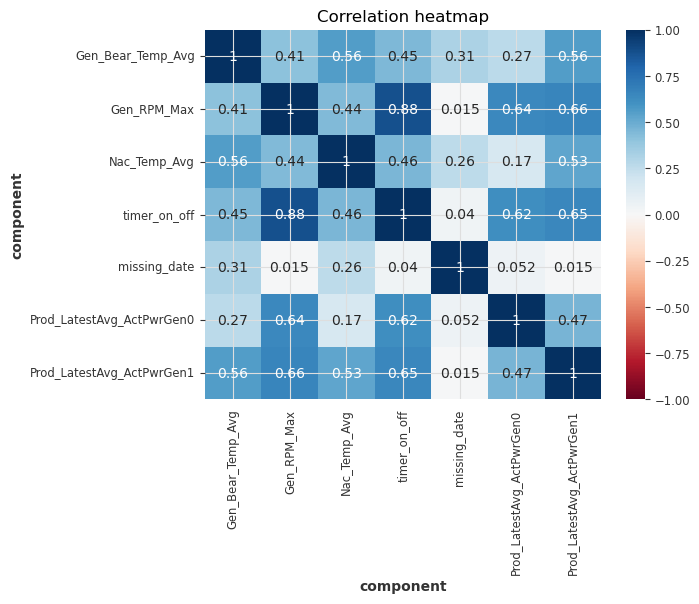

In [10]:
from darts.dataprocessing.transformers import Scaler
import seaborn as sb

times = slice(1000, 2000)

def plot_feature_analysis(series, tg_col, cov_cols):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
    
    # target over time
    series[tg_col][times].plot(ax=ax1)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # scale covariates to (0, 1) for better visibility
    Scaler().fit_transform(series[cov_cols])[times].plot(ax=ax2)
    ax1.set_title("Temperature")
    ax2.set_title("External Features")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    plt.show()
    
    # correlation heatmap
    fig, ax = plt.subplots()
    df_feats = pd.concat([series[tg_col].pd_dataframe(), series[cov_cols].pd_dataframe()], axis=1) 
    dataplot = sb.heatmap(
        df_feats.corr(), cmap="RdBu", annot=True, ax=ax, vmin=-1, vmax=1)
    ax.set_title("Correlation heatmap")
    plt.show()

plot_feature_analysis(train_raw, tg_col, cov_cols)

All covariates show positive correlation with the generator bearing temperature.
The nacelle temperature (e.g. changes in temperature during the day and throughout the year) and power generation have the highest positive correlation.

Features Gen_RPM_Max and Prod_LatestAvg_ActPwrGen0/1 are relatively noisy due to frequent fluctuations. We can apply a moving average filter to reduce noise and potentially increase the correlation.

In [11]:
from darts.models import MovingAverageFilter

# filter the noisy features...
filter_cols = [
    "Gen_RPM_Max", 
    "Prod_LatestAvg_ActPwrGen0",
    "Prod_LatestAvg_ActPwrGen1",
]
# ... with a 2 hour window = 2 * 6 (10 minute steps) = 12
filter_window = 12

def filter_signals(series, cols):
    """Apply a moving average filter to selected signals for noise reduction"""
    
    # filter with a predifined window size
    maf = MovingAverageFilter(window=filter_window)
    cols_filtered = maf.filter(series[cols])
    
    # the filter renames the columns so we have to revert that
    cols_other = series.columns.drop(cols).tolist()
    renamed_cols = [f"rolling_mean_{filter_window}_" + col for col in filter_cols]
    cols_filtered = cols_filtered.with_columns_renamed(renamed_cols, cols)
    
    # return a new series with the filtered signals
    return series[cols_other].stack(cols_filtered)

# filtering
train_raw = filter_signals(train_raw, filter_cols)
test_raw = filter_signals(test_raw, filter_cols)

And we plot it again

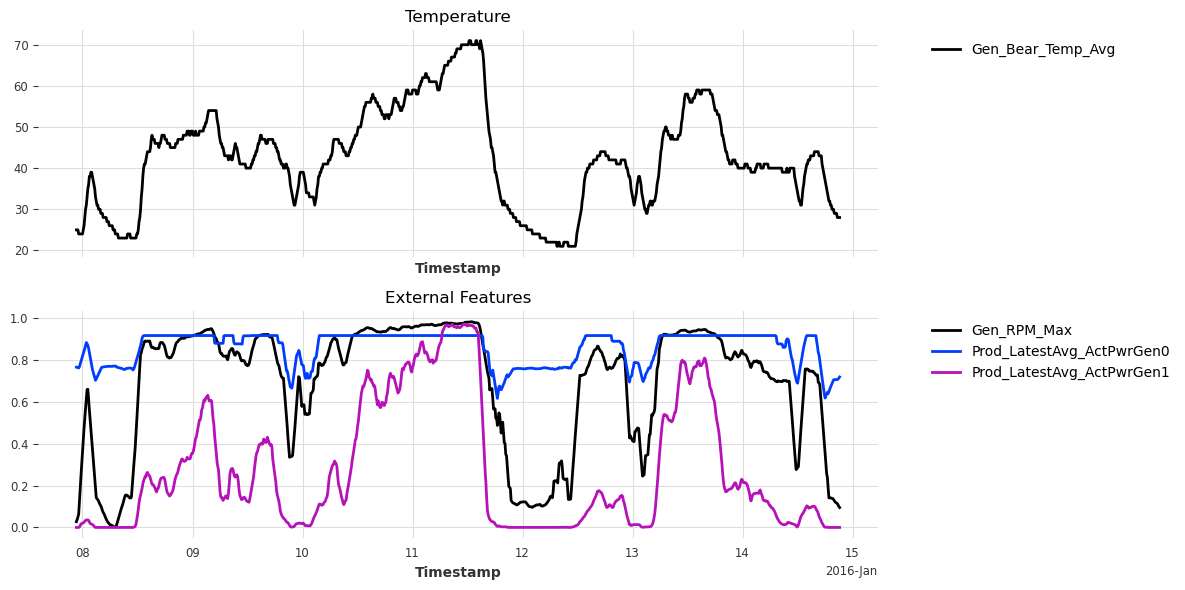

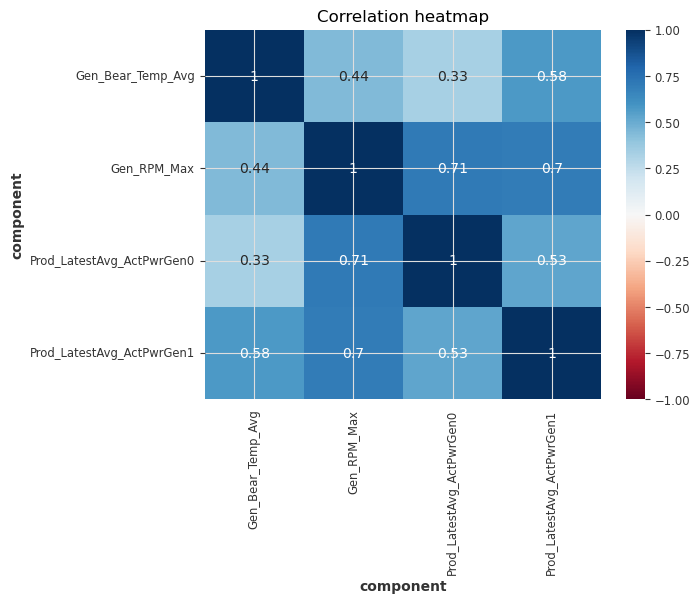

In [12]:
plot_feature_analysis(train_raw, tg_col, filter_cols)

Indeed, it did increase the correlation.

Great, now we are ready to start with preparing the data for the modelling!

## Dataset Preparation for Training

### Anomaly Removal
We want to estimate the normal operating range of the generator temperature. For this, we must train the model on an anomaly-free data. This can be done in different ways:

- Split TimeSeries into several series that do not contain anomaly time frames
- Generate a binary anomaly flag, mark anomalous time frames in training TimeSeries as `True`, and at prediction time as `False`. Use this feature as model input.

Let's go with the latter option. Let's create a function that "removes" the known anomalies, including the preceding and following 7 days (2 week buffer window). 

> We also remove the non-generator-specific anomalies, since we have no guarantee that the generator was not affected by them.

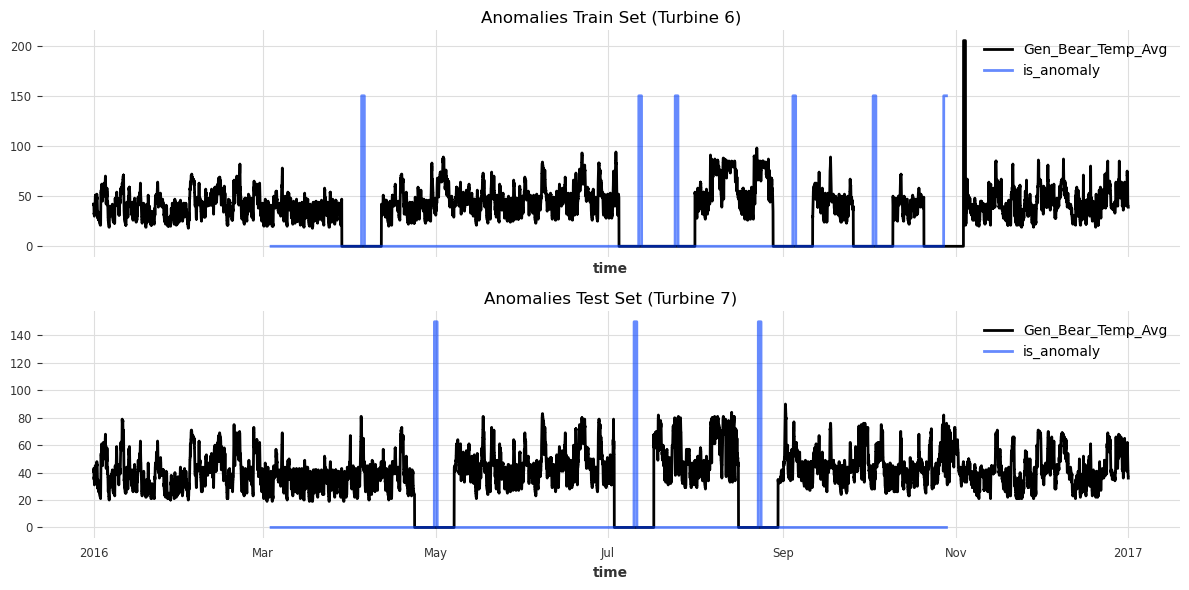

In [13]:
def remove_anomalies(
    series: TimeSeries,
    tg_col: str,
    anomalies_df: pd.DataFrame,
    turbine_id: str,
):
    """Return a new TimeSeries with removed anomalies (including the last and following 7 days). Removed anomalies meaning:

    - all covariate values are replaced with `np.nan`
    - flag "missing_date" is set to `True`
    - target values are set to `0.`
    """
    df = series.pd_dataframe(copy=True)
    one_week = FREQ * 6 * 24 * 7

    # mask all anomalous time frames
    anom_mask = np.zeros(len(series)).astype(bool)
    anom_turb = anomalies_df[anomalies_df["Turbine_ID"] == turbine_id].reset_index(drop=True)
    for start in anom_turb["start"]:
        anom_mask = anom_mask | ((series.time_index >= start - one_week) & (series.time_index <= start + one_week))

    df.loc[anom_mask, :] = np.nan
    df.loc[anom_mask, tg_col] = 0.
    df.loc[anom_mask, "missing_date"] = 1.
    return TimeSeries.from_dataframe(df)

# data cleaning (remove anomalies)
train = remove_anomalies(
    series=train_raw,
    tg_col=tg_col,
    anomalies_df=df_anom_true,
    turbine_id=turbine_id_train,
)
test = remove_anomalies(
    series=test_raw,
    tg_col=tg_col,
    anomalies_df=df_anom_true,
    turbine_id=turbine_id_test,
)

plot_series(train, test, anom_true)

### Target and Covariates Extraction for Training and Validation Set

Now we extract the target series and covariates to train the model.
We'll use `CatBoostModel` which support a validation set for early stopping to reduce overfitting.

We use the entire year 2016 of the anomaly-free Turbine 6 data for training. For the validation set, we use the first 10k points of Turbine 7 (roughly two months).

In [14]:
# extract target variable
tg_train = train[tg_col]
tg_test = test[tg_col]

# extract covariates
covs_train = train[cov_cols]
covs_test = test[cov_cols]

# for early stopping
tg_val = tg_test[:10000]
covs_val = covs_test[:10000]

## Model Setup And Training

> **Reminder:** Because our predictive maintenance algorithm is done post hoc, we can model the generator temperature at all times `t` with actual measurement data from other sensors at times `t` (in regular forecasting, we wouldn't know these values as they lie in the future).


To perform this task, we set up the model as follows:

- We train the model to predict only one step `t` at a time -> `output_chunk_length=1`
- We train a probabilistic model to forecast temperature quantiles (0.05, 0.50, 0.95) which we will use a proxy for the normal range (`likelihood="quantile", quantiles=[0.05, 0.50, 0.95]`)
- We **don't use** the past of the temperature as a model input (because of the causal flow) -> `lags=None`
- We only use external features (future covariates) because we can use information at time `t` to predict the temperature at time `t` -> `lags_future_covariates`
- Additionally we add some calendar information (the month and hour of the day) as predictors for some seasonal patterns (e.g. the month for the different seasons, hour for day and night) -> `add_encoders`

In [15]:
# model setup
# add calendar information
add_encoders = {"cyclic": {"future": ["month", "hour"]}}

# define the lagged feature values:
# by default, use the last 4 hours and curent value `(24 * 10 minutes, 1)`
# for the month, use only the current value `[0]`
lags_future_covariates = {
    "default_lags": (24, 1),
    "darts_enc_fc_cyc_month_sin": [0],
    "darts_enc_fc_cyc_month_cos": [0],
}
# define the quantile to be fitted
quantiles = [0.05, 0.5, 0.95]

# create the model
from darts.models import CatBoostModel
model = CatBoostModel(
    lags=None,
    lags_future_covariates=lags_future_covariates,
    output_chunk_length=1,
    add_encoders=add_encoders,
    likelihood="quantile",
    quantiles=quantiles,
    random_state=42,
)

# train the model with a validation set to prevent overfitting
model.fit(
    series=tg_train,
    future_covariates=covs_train,
    val_series=tg_val,
    val_future_covariates=covs_val,
)

CatBoostModel(lags=None, lags_past_covariates=None, lags_future_covariates={'default_lags': (24, 1), 'darts_enc_fc_cyc_month_sin': [0], 'darts_enc_fc_cyc_month_cos': [0]}, output_chunk_length=1, output_chunk_shift=0, add_encoders={'cyclic': {'future': ['month', 'hour']}}, likelihood=quantile, quantiles=[0.05, 0.5, 0.95], random_state=42, multi_models=True, use_static_covariates=True)

## Model Evaluation

### Anomaly-Free Turbine 6 Forecasts

Now we should check how the model performed. First, we take a look at the anomaly-free (cleaned) Turbine 6 data from 2016.
Ideally, if we let our model forecast the entire year, we shouldn't detect any major anomalous behavior.

We generate the historical forecasts over the year 2016 and show the predictions for the entire year, and the first couple of days.

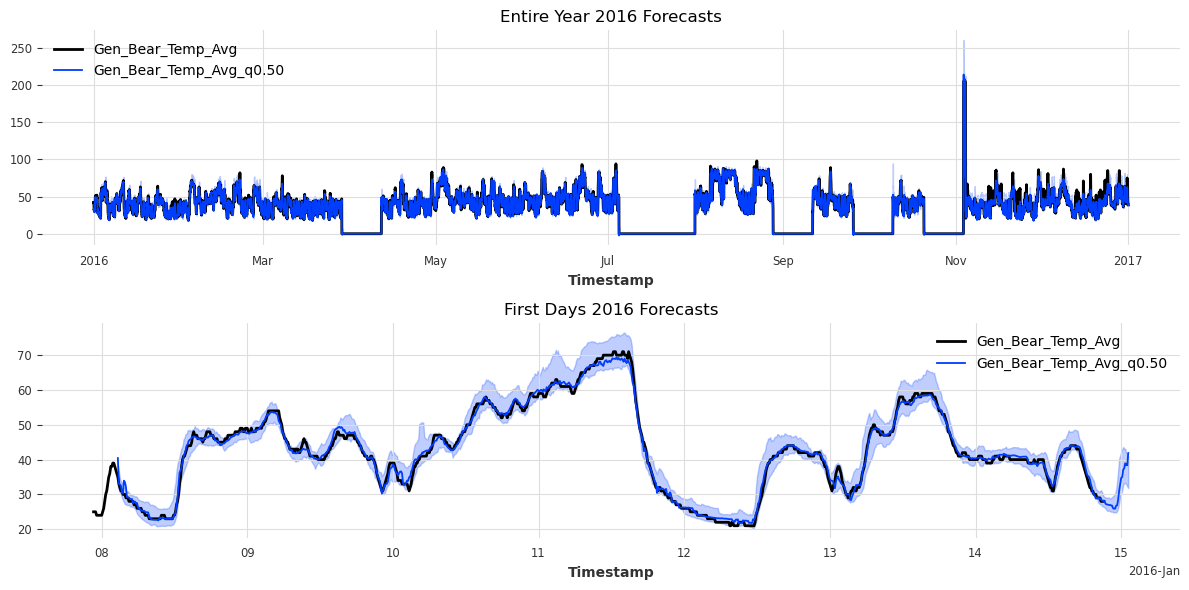

In [16]:
hist_fc_params = {
    "forecast_horizon": 1,  # one step predictions
    "stride": 1,  # move by one step for next prediction
    "last_points_only": True,  # return a contiguous forecast from all predictions
    "retrain": False,  # use the pre-trained model
    "predict_likelihood_parameters": True,  # predict the quantiles directly
}

hist_fc_train = model.historical_forecasts(
    series=tg_train, future_covariates=covs_train, **hist_fc_params
)

# we added a helper function to plot the quantile predictions as intervals
from src.predictive_maintenance import plot_intervals

def plot_hist_fcs(series, hist_fc):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6))
    series.plot(ax=ax1)
    plot_intervals(hist_fc, ax=ax1)
    ax1.set_title("Entire Year 2016 Forecasts")
    
    series[times].plot(ax=ax2)
    plot_intervals(hist_fc[times], ax=ax2)
    ax2.set_title("First Days 2016 Forecasts")
    
    fig.tight_layout()
    plt.show()

plot_hist_fcs(tg_train, hist_fc_train)

The graph shows the actual temperature in black, predicted median temperature in blue (quantile 0.50), and the estimated normal operating range as a light blue interval (upper bound = quantile 0.95, lower bound = quantile 0.05).

These predictions look rather nice, but it's also the data that the model has been trained on. Nevertheless, let's continue the investigation.

Let's also remove predictions at times when the flag "missing_date" was `True`, since these could also not be forecasted properly in the real-world scenario.

In [17]:
def postprocess_preds(series: TimeSeries, covs: TimeSeries):
    """Return a new series, where the values have bin replaced with 
    `np.nan` where flag 'is_missing' is `True`.
    """
    vals = series.values(copy=True)
    is_missing = covs["missing_date"].slice_intersect_values(series, copy=False)[:, 0, 0]
    vals[is_missing == 1.] = np.nan
    return series.with_values(vals)

hist_fc_train = postprocess_preds(hist_fc_train, covs_train)

### Residuals Computation
What we are interested in is: how often and by how much was the actual temperature outside the predicted normal operating range?

For this, we can compute the residuals per predicted quantile.

Text(0.5, 1.0, 'Residuals per quantile for the first days')

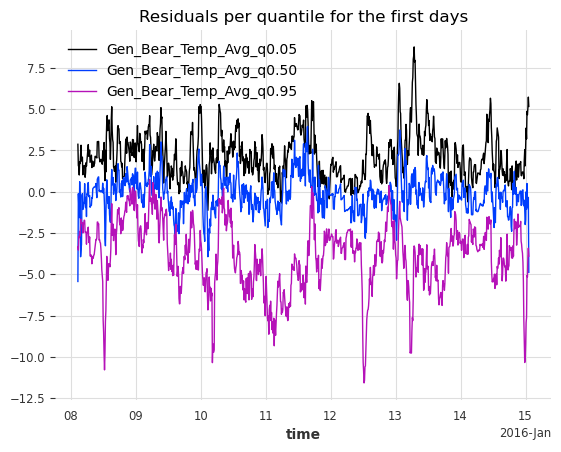

In [18]:
from darts import concatenate

# repeat target column so when can compute the residuals per quantile
train_ext = concatenate([tg_train] * 3, axis=1)
residuals = model.residuals(
    series=train_ext,
    historical_forecasts=hist_fc_train,
    last_points_only=True,
)

ax = residuals[times].plot(lw=1)
ax.set_title("Residuals per quantile for the first days")

The residuals are computed as `y_true - y_pred`, so we can find out when the actual temperature was above or below the interval when:

- actual temperature is below if `q0.05 > 0`
- actual temperature is above if `q0.95 < 0`

From now on, we only focus on the times when one of these two conditions was met.

In [19]:
df = residuals.pd_dataframe(copy=True)

# rename the residuals to something shorter
dev_lo, dev_md, dev_hi, dev_agg = ["dev_lo", "dev_md", "dev_hi", "dev_agg"]
df.columns = [dev_lo, dev_md, dev_hi]

# let's drop the median prediction
df = df[[dev_lo, dev_hi]]

# fill missing dates predictions with zeros.
df = df.fillna(0.)

# ignore residuals where y_true was within high and low quantile
# points below the lower bound
df.loc[df[dev_lo] > -0., dev_lo] = 0.
# points above the upper bound
df.loc[df[dev_hi] < 0., dev_hi] = 0.
# points above or below the interval
df.loc[:, dev_agg] = df[dev_lo] + df[dev_hi]

# compute the share of anomalous time steps for each condition 
(df != 0).mean() * 100

dev_lo     3.471906
dev_hi     3.758542
dev_agg    7.230448
dtype: float64

So, 3.5% of actual temperatures were above the interval, 3.8% were below, giving a total 7.2% out of bounds.

This looks fine, as our quantile interval should include roughly 90% of all actual values.

Let's quickly look at the residual analysis:

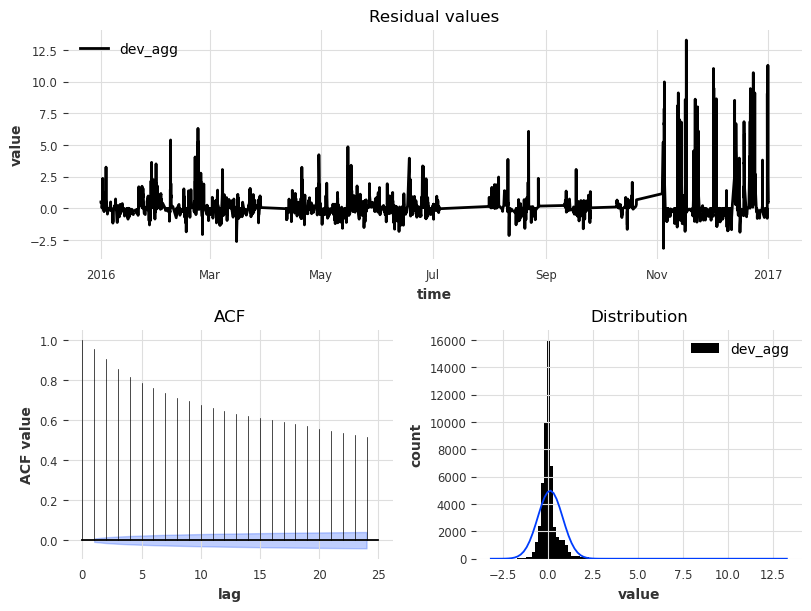

In [20]:
# replace 0. values with np.nan to ignore them for the residuals analysis
df_ = df[[dev_agg]].copy()
df_[df_ == 0.] = np.nan

from darts.utils.statistics import plot_residuals_analysis
plot_residuals_analysis(TimeSeries.from_dataframe(df_), num_bins=100)

From January until November 2016, the residuals seem rather stable. Interestingly, from November onwards, the residuals tend to be much larger. We either miss some important feature/measurement that can explain these deviations, or the temperature measurements in this time frame are actually showing an anomalous behavior.

> **Tip:** In such cases it is strongly recommended to communicate with the engineers/operators/... to find an explanation for it.

### Anomaly Detection

Okay, now we can start defining what we consider as an anomaly. A single point being slightly outside the interval can always happen by chance. Instead, let's try to find some significant anomalies. For this, we can apply the following:
- we could ignore some points which were only slightly outside the interval (threshold `min_value`)
- we scan our residuals in fixed size windows and count how many points were out-of bounds in each window (`anom_window`)
- for each window we can set a minimum out-of-bounds probability below which we do not consider the window as anomalous (`min_anom_prob`)

Since this is a non-trivial operation, we provide a helper function `compute_anomalies()` for it.
The function performs all steps from above, including the residuals computation. It returns

- `anom_pred`: the residuals ("dev_lo", ...) and final anomaly flags ("anom_lo", ...) as a `TimeSeries`.
- `df_anom_pred`: a `DataFrame` where each row represents an anomaly, including the start, end date and some statistics
- `ql`: the quantile loss for the historical forecast (as a metric of how good the quantile predictions are; with zero being the best score).

In [21]:
from src.predictive_maintenance import compute_anomalies

# anomaly detection settings
min_value = 2.  # minimum 2 degrees outside
anom_window = 6*24  # a one day window
min_anom_prob = 0.25  # minimum 25% of points should be out of bounds in a window

anom_train_pred, df_anom_train_pred, ql_train = compute_anomalies(
    model=model,
    series=tg_train,
    pred_series=hist_fc_train,
    quantiles=quantiles,
    min_value=min_value,
    anom_window=anom_window,
    min_anom_prob=min_anom_prob,
)
anom_train_pred[["anom_lo", "anom_hi", "anom_agg"]].pd_dataframe().mean(axis=0) * 100

component
anom_lo     0.000000
anom_hi     0.474563
anom_agg    0.474563
dtype: float64

In [22]:
df_anom_train_pred = df_anom_train_pred[df_anom_train_pred["name"] == "anom_agg"]
df_anom_train_pred = df_anom_train_pred.sort_values(by="dev_tot", ascending=False).reset_index(drop=True)
df_anom_train_pred

start                 end  n_steps     dev_tot      name
0 2016-12-01 06:40:00 2016-12-03 00:10:00      250  273.661477  anom_agg

With this setting, we only marked a single time period as anomalous. It also lies at the end of 2016 where we identified the larger residual values before.

> The `min_anom_prob` value can be calibrated by comparing the predicted anomalies on the anomaly-free series (should give roughly zero anomalies) with the predicted anomalies on the anomalous series (should find roughly as many anomalies as there are true anomalies)

And now we visualize the predicted anomaly with helper function `plot_predicted_anomalies()`:

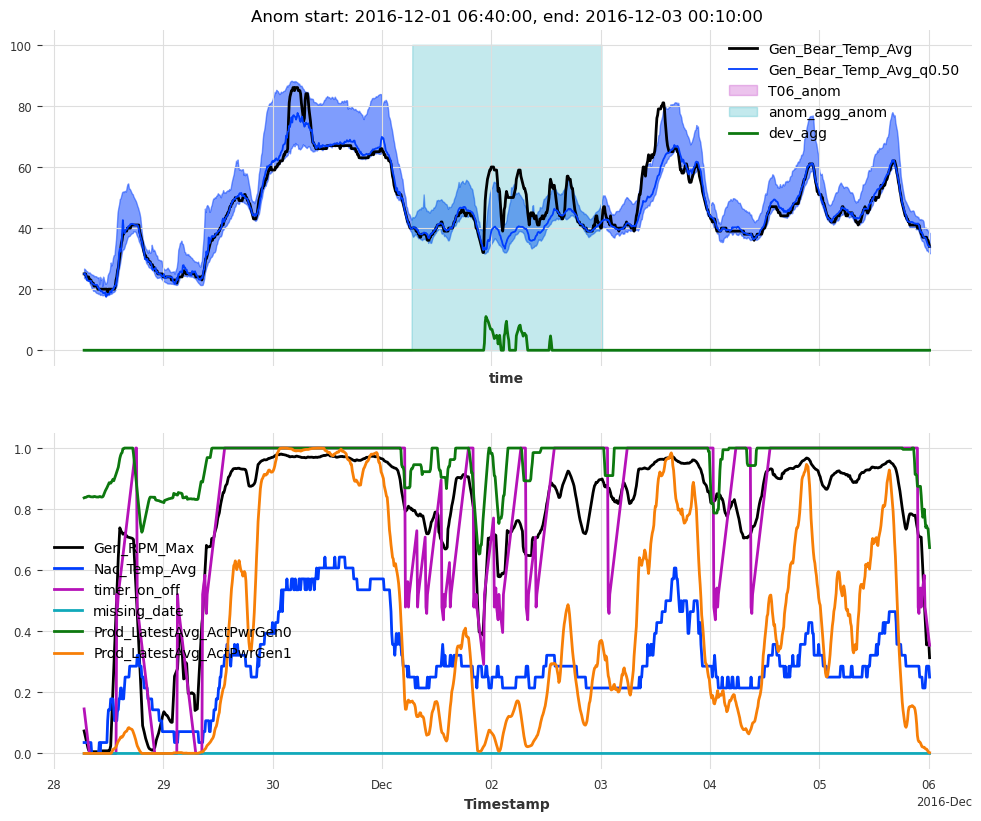

In [23]:
from src.predictive_maintenance import plot_predicted_anomalies
plot_predicted_anomalies(
    df_anom_train_pred,
    tg_train,
    covs_train,
    hist_fc_train,
    anom_true,
    anom_train_pred,
    turbine_id_train,
)

This graph shows us:
- Top: actual temperature (black), predicted normal operating range (blue), predicted anomaly window (green capsule), residual value if actual temperature was out of bounds (green), actual anomaly (red, only if there was an actual anomaly)
- Bottom: the covariates scaled to a value range (0, 1)

### Turbine 6 Forecasts On Anomalous Data

All in all, our model seems properly configured now on the training data with the removed anomalies. 

Now, let's see how the model performs when we add back the anomalous time frames into the Turbine 6 data.

For simplicity, we make use of our helper functions directly:

In [24]:
tg_train_anom = train_raw[tg_col]
covs_train_anom = train_raw[cov_cols]

hist_fc_train_anom = model.historical_forecasts(
    series=tg_train_anom, future_covariates=covs_train_anom, **hist_fc_params
)

hist_fc_train_anom = postprocess_preds(hist_fc_train_anom, covs_train_anom)
anom_train_anom_pred, df_anom_train_anom_pred, ql_train_anom = compute_anomalies(
    model=model,
    series=tg_train_anom,
    pred_series=hist_fc_train_anom,
    quantiles=quantiles,
    min_value=min_value,
    anom_window=anom_window,
    min_anom_prob=min_anom_prob,
)

df_anom_train_anom_pred = df_anom_train_anom_pred[df_anom_train_anom_pred["name"] == "anom_agg"]
df_anom_train_anom_pred = df_anom_train_anom_pred.sort_values(by="dev_tot", ascending=False).reset_index(drop=True)
df_anom_train_anom_pred.head(10)

start                 end  n_steps      dev_tot      name
0 2016-07-21 02:50:00 2016-07-25 14:30:00      647  2312.724579  anom_agg
1 2016-10-01 00:40:00 2016-10-03 02:40:00      301   496.136290  anom_agg
2 2016-07-09 09:00:00 2016-07-11 04:40:00      263   297.790640  anom_agg
3 2016-12-01 06:40:00 2016-12-03 00:10:00      250   273.661477  anom_agg
4 2016-10-29 04:20:00 2016-11-03 05:30:00      728   -61.884456  anom_agg
5 2016-10-27 11:50:00 2016-10-28 13:30:00      155   -66.921392  anom_agg

It looks like now we predict more anomalies with much larger total deviation. Let's check them visually:

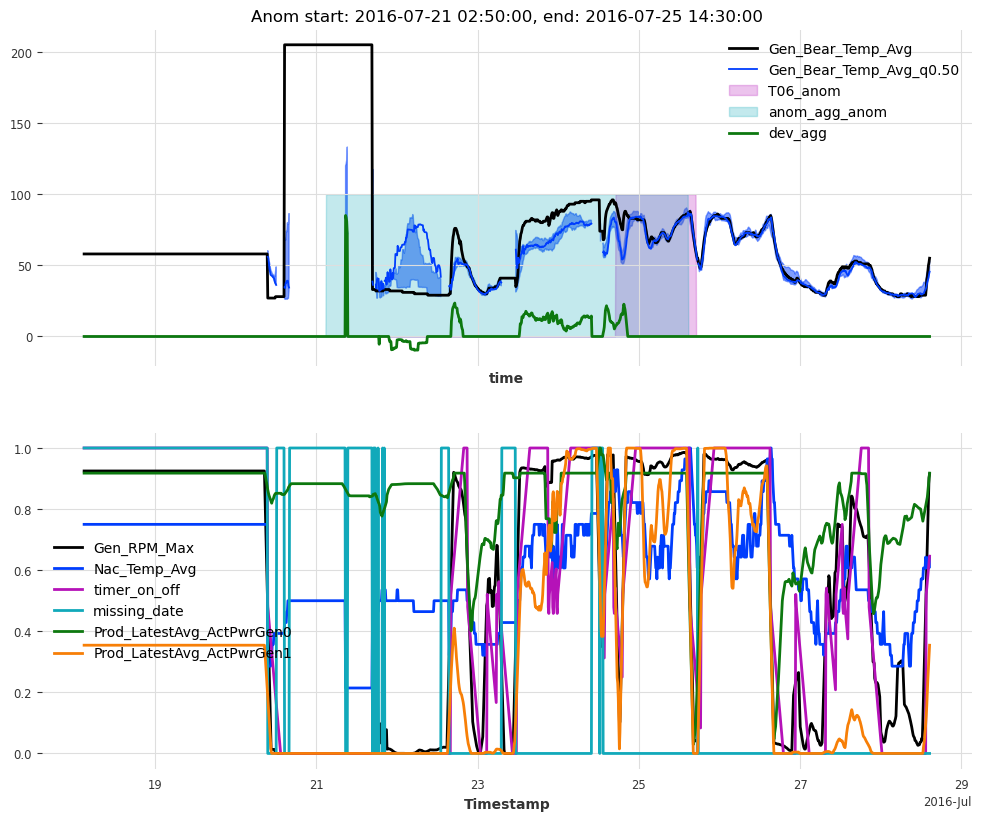

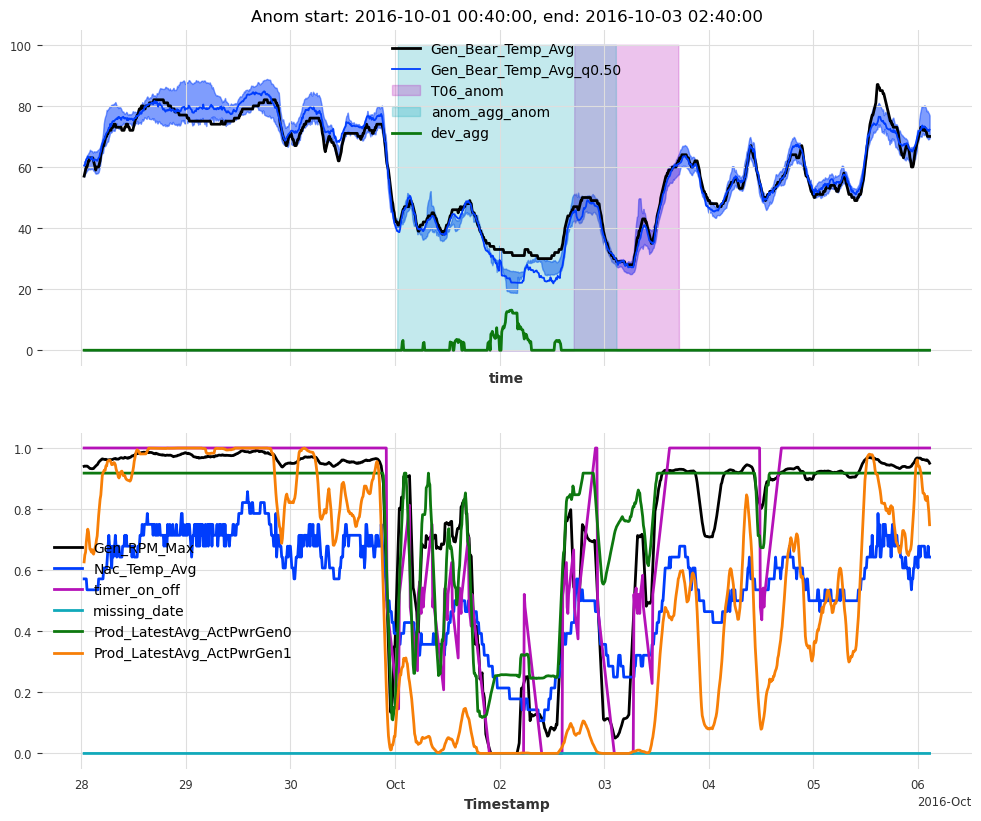

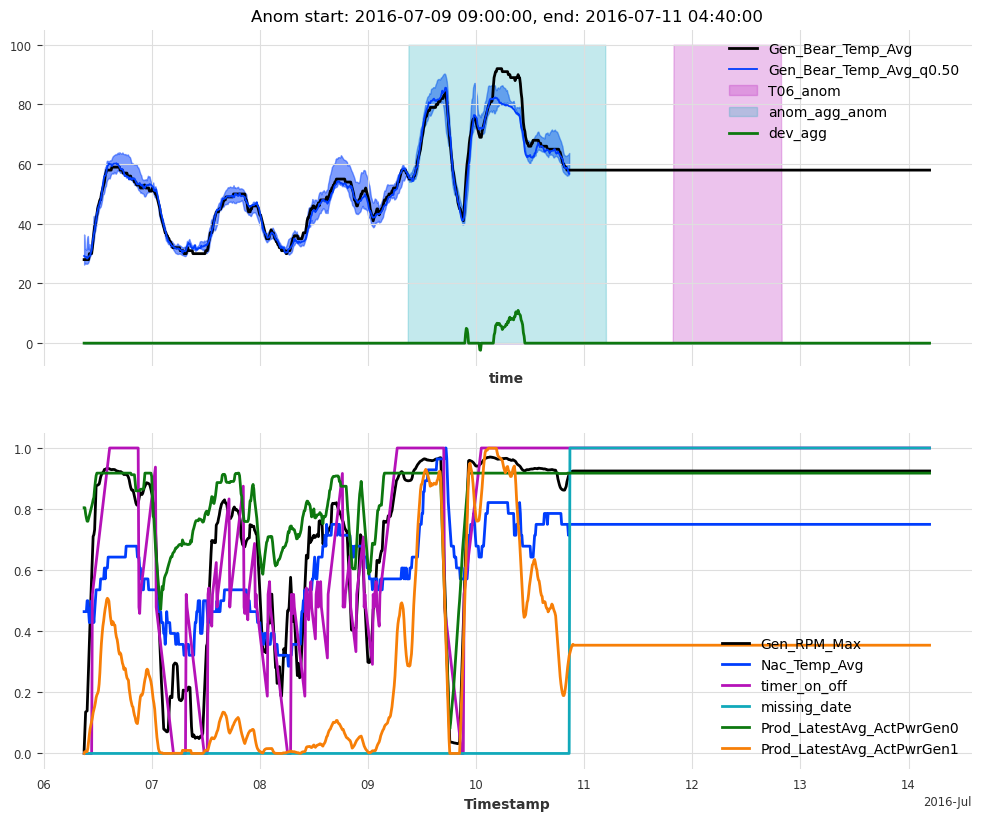

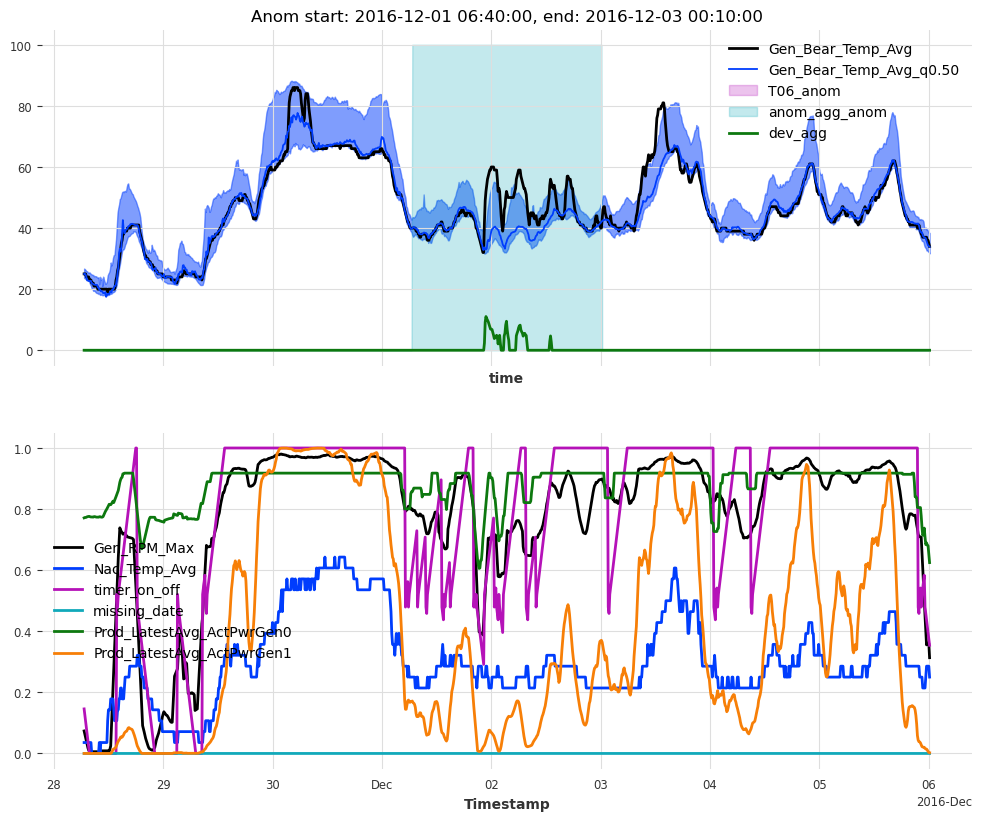

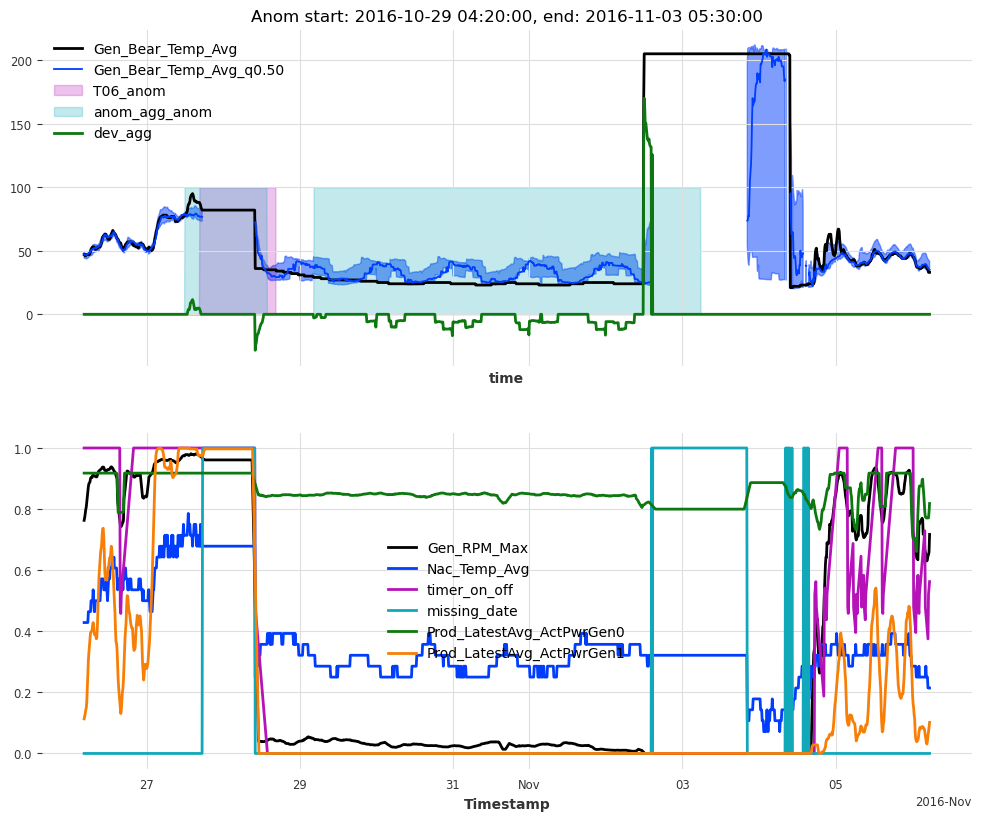

In [25]:
plot_predicted_anomalies(
    df_anom_train_anom_pred,
    tg_train_anom,
    covs_train_anom,
    hist_fc_train_anom,
    anom_true_gen,
    anom_train_anom_pred,
    turbine_id_train,
)

This looks great, as we can see actual anomalies (red capsules) in almost all the examples! And now plot actual vs predict anomalies throughout 2016.

<Axes: xlabel='time'>

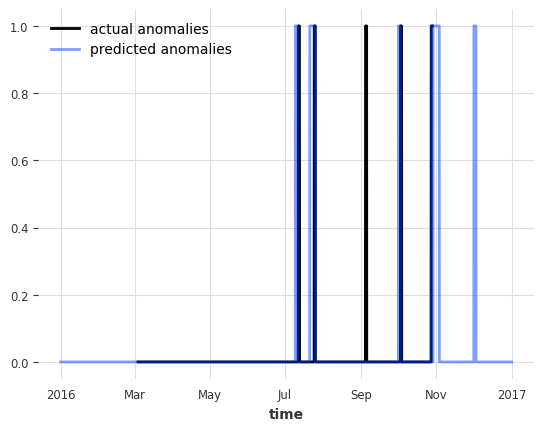

In [26]:
anom_true_gen[turbine_id_train].plot(label="actual anomalies")
anom_train_anom_pred["anom_agg"].plot(alpha=0.5, label="predicted anomalies")

The model correctly detected all anomalies except number 3 from the left! The last predicted anomaly is the one that we saw already on the anomaly-free input data.

### Turbine 7 Forecasts On Anomalous Data

As a last step, let's see how the model performs in detecting anomalies on turbine 7.
Remember, this **model has not been trained on this turbine at all** (only the first 2 months were used for early stopping, not learning).

In [27]:
tg_test_anom = test_raw[tg_col]
covs_test_anom = test_raw[cov_cols]

hist_fc_test_anom = model.historical_forecasts(
    series=tg_test_anom, future_covariates=covs_test_anom, **hist_fc_params
)

hist_fc_test_anom = postprocess_preds(hist_fc_test_anom, covs_test_anom)
anom_test_anom_pred, df_anom_test_anom_pred, ql_test_anom = compute_anomalies(
    model=model,
    series=tg_test_anom,
    pred_series=hist_fc_test_anom,
    quantiles=quantiles,
    min_value=min_value,
    anom_window=anom_window,
    min_anom_prob=min_anom_prob,
)

df_anom_test_anom_pred = df_anom_test_anom_pred[df_anom_test_anom_pred["name"] == "anom_agg"]
df_anom_test_anom_pred = df_anom_test_anom_pred.sort_values(by="dev_tot", ascending=False).reset_index(drop=True)
df_anom_test_anom_pred.head(10)

start                 end  n_steps      dev_tot      name
0 2016-04-28 22:40:00 2016-05-01 02:50:00      314  1154.143814  anom_agg
1 2016-04-04 11:10:00 2016-04-05 15:30:00      171   288.239333  anom_agg
2 2016-09-03 00:10:00 2016-09-04 08:50:00      197   244.797453  anom_agg
3 2016-08-31 21:00:00 2016-09-02 17:50:00      270   207.687711  anom_agg
4 2016-01-10 08:00:00 2016-01-12 02:40:00      257   198.605457  anom_agg
5 2016-10-20 09:40:00 2016-10-22 01:00:00      237   158.428421  anom_agg
6 2016-09-28 12:50:00 2016-09-29 14:40:00      156   139.718538  anom_agg
7 2016-05-05 19:30:00 2016-05-07 13:40:00      254  -113.090398  anom_agg

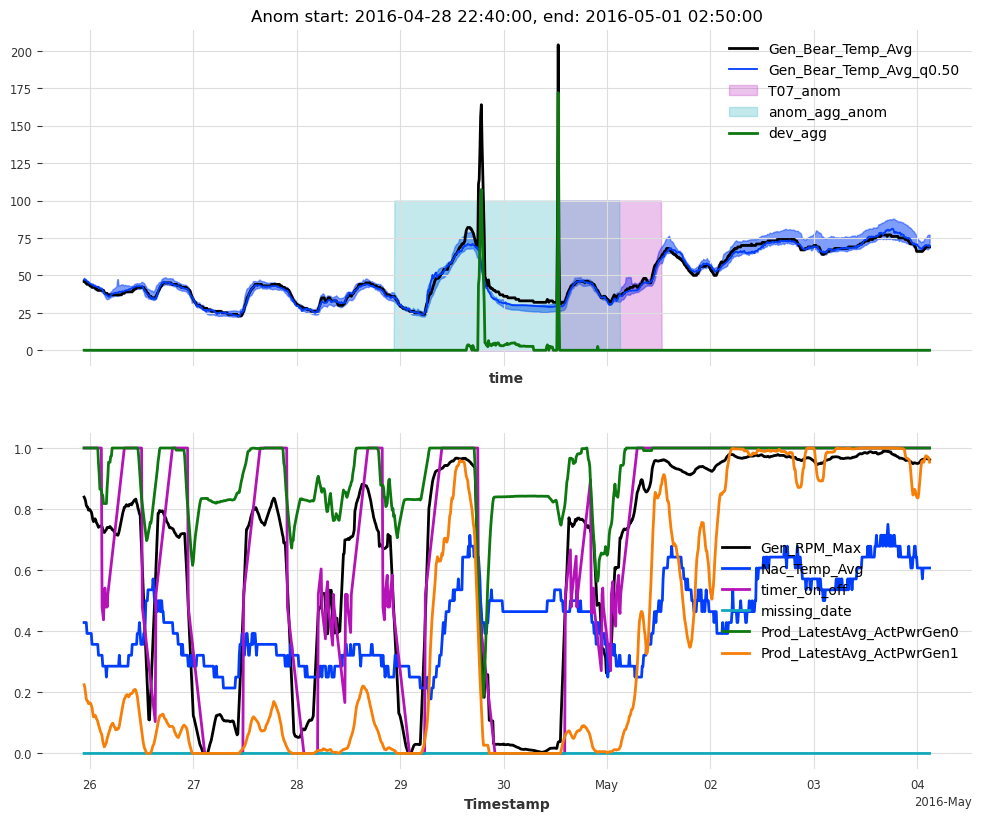

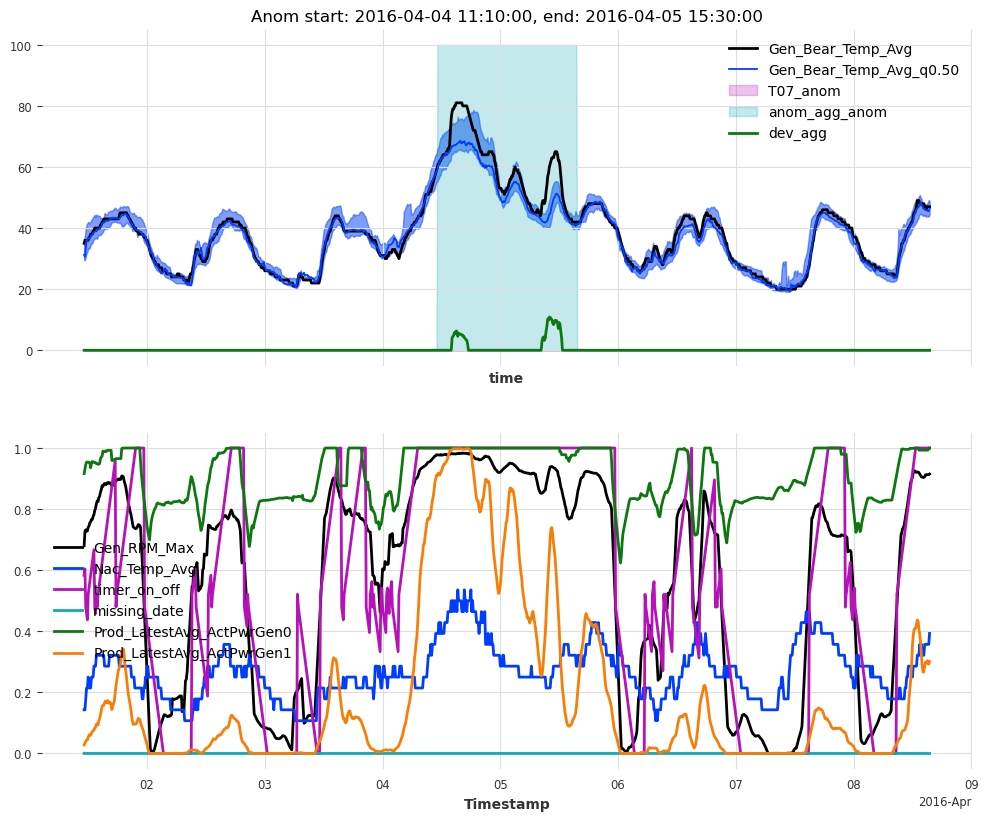

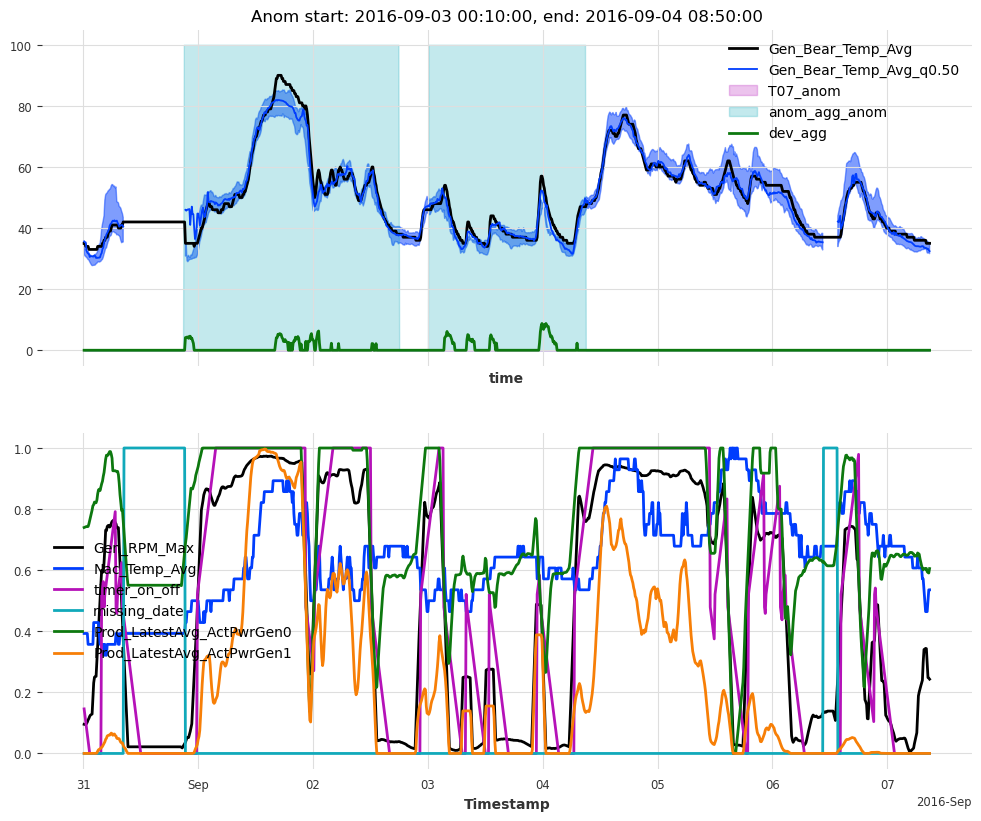

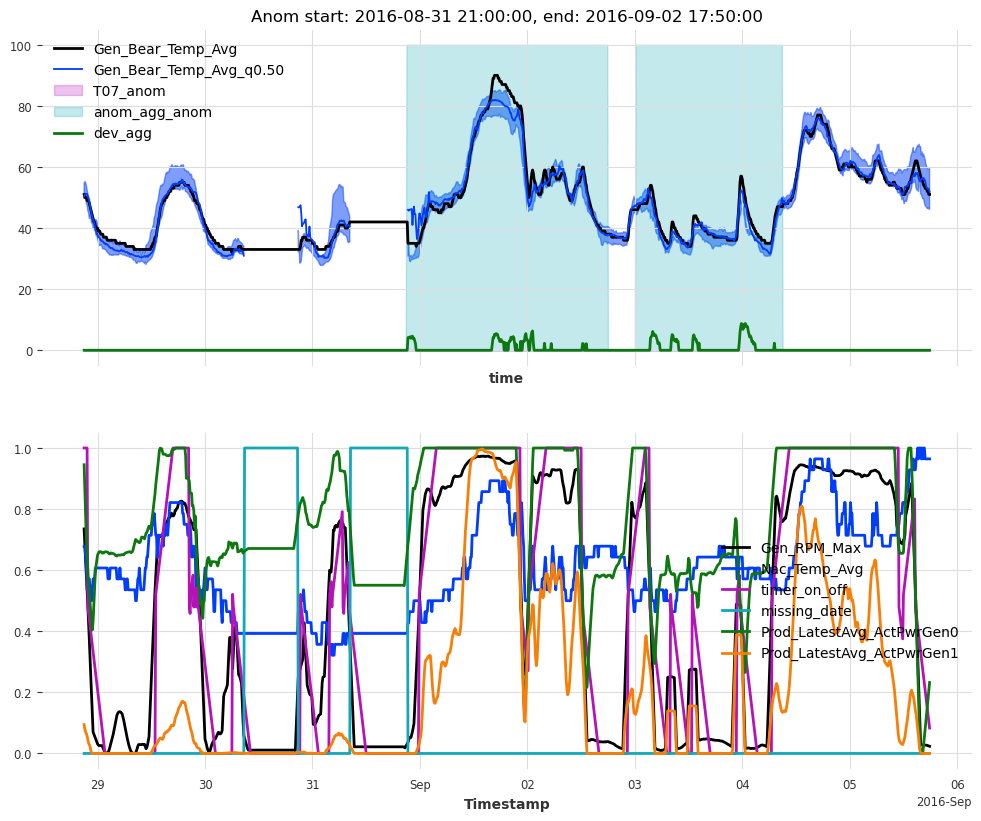

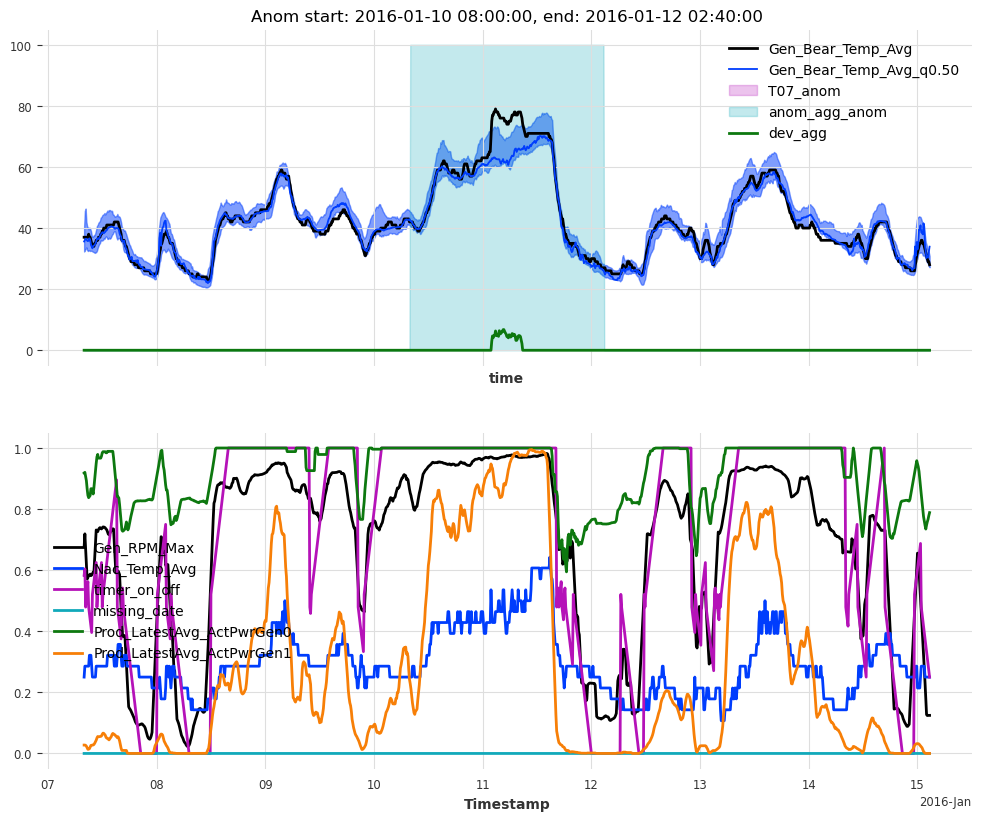

In [28]:
plot_predicted_anomalies(
    df_anom_test_anom_pred,
    tg_test_anom,
    covs_test_anom,
    hist_fc_test_anom,
    anom_true_gen,
    anom_test_anom_pred,
    turbine_id_test,
)

The most significant predicted anomaly (the first one in order) is also an actual anomaly (and the only actual generator anomaly).
All other predicted anomalies have much lower total deviation (residuals). This is an excellent result, considering that the model has not been trained on this turbine.

<Axes: xlabel='time'>

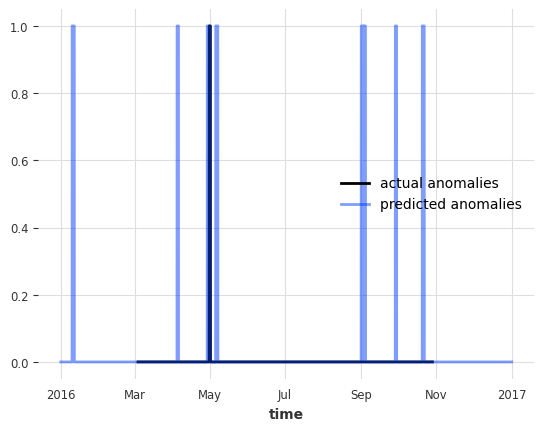

In [29]:
anom_true_gen[turbine_id_test].plot(label="actual anomalies")
anom_test_anom_pred["anom_agg"].plot(alpha=0.5, label="predicted anomalies")

## Conclusion

We showed how to perform a predictive maintenance task using Darts on the example of Wind Turbine Failures. We looked at:
- which features to use (and not use) for modelling
- how to setup and train a model to predict the expected normal operating range of a signal
- how to detect anomalies from deviations between the actual signal values and the predicted operating range

Since this was an open-source dataset, we did not have the chance to communicate with the engineers/operators of the turbines.
To further the results, it would be crucial to further investigate with them:
- if there are other relevant features for modelling the temperature signal
- if there is an explanation why the residuals are higher at the end of the year
- ...

And in general, to improve the results: We only modeled one temperature signal in this example. For a real predictive maintenance pipeline, we would:
- have dedicated models for different signals
- perform the anomaly detection for each signal
- from these results, we can draw conclusions on origin of anomaly